# Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import psycopg2 as pg
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', palette = 'Paired')
#plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
np.set_printoptions(suppress=True) # Suppress scientific notation where possible
from ipywidgets import interactive, FloatSlider

from sklearn.inspection import permutation_importance
from sklearn import linear_model, svm, naive_bayes, neighbors, ensemble
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix,\
roc_auc_score, roc_curve, precision_recall_curve, f1_score, fbeta_score, recall_score,\
precision_recall_fscore_support

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)
from sklearn.metrics import accuracy_score, make_scorer, log_loss

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from mlxtend.plotting import plot_decision_regions

import xgboost as xgb

# Minimum Viable Product

Let's find a base model to begin with

In [2]:
df = pd.read_csv('/Users/dominguez/Documents/project3/Data/df.csv')

In [3]:
# Establish features and target variables

X = df.loc[:,'limit_bal':'Apr_Pmt']

y = df['Default']

In [4]:
# Establish catericals and numericals and put column names in 2 lists

categoricals = ['sex','education','marriage']
numericals = ['limit_bal','age','Sep_Hist','Jul_Hist', 'Jun_Hist', 'May_Hist', 'Apr_Hist',
              'Aug_Hist', 'Sep_Bal','Aug_Bal', 'Jul_Bal', 'Jun_Bal', 'May_Bal', 'Apr_Bal', 'Sep_Pmt',
              'Aug_Pmt', 'Jul_Pmt', 'Jun_Pmt', 'May_Pmt', 'Apr_Pmt']

def encode_cats(categoricals, numericals):
    """
    Takes in a list of categorical columns and a list of numerical columns and returns the dataframe with encoded variables
    """
    ohe = OneHotEncoder(sparse=False, drop='first')
    cat_matrix = ohe.fit_transform(X.loc[:, categoricals])
    X_ohe = pd.DataFrame(cat_matrix,
                         columns=ohe.get_feature_names(categoricals), #create meaningful column names
                         index=X.index) #keep the same index values
    
    return pd.concat([X.loc[:, numericals], X_ohe], axis=1)

In [5]:
X = encode_cats(categoricals, numericals)

,limit_bal,age,Sep_Hist,Jul_Hist,Jun_Hist,May_Hist,Apr_Hist,Aug_Hist,Sep_Bal,Aug_Bal,...,Jul_Pmt,Jun_Pmt,May_Pmt,Apr_Pmt,sex_male,education_highschool,education_other,education_university,marriage_other,marriage_single
0,20000,24,4,4,1,1,0,0,3913,3102,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
1,120000,26,1,4,2,2,2,4,2682,1725,...,1000,1000,0,2000,0.0,0.0,0.0,1.0,0.0,1.0
2,90000,34,2,2,2,2,2,2,29239,14027,...,1000,1000,1000,5000,0.0,0.0,0.0,1.0,0.0,1.0
3,50000,37,2,2,2,2,2,2,46990,48233,...,1200,1100,1069,1000,0.0,0.0,0.0,1.0,0.0,0.0
4,50000,57,1,2,1,2,2,2,8617,5670,...,10000,9000,689,679,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,39,2,2,2,2,2,2,188948,192815,...,5003,3047,5000,1000,1.0,1.0,0.0,0.0,0.0,0.0
29996,150000,43,1,1,1,1,2,2,1683,1828,...,8998,129,0,0,1.0,1.0,0.0,0.0,0.0,1.0
29997,30000,37,6,5,4,1,2,2,3565,3356,...,22000,4200,2000,3100,1.0,0.0,0.0,1.0,0.0,1.0
29998,80000,41,3,1,2,2,2,1,-1645,78379,...,1178,1926,52964,1804,1.0,1.0,0.0,0.0,0.0,0.0


In [13]:
# Let's find our base model

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Split train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Validate

print("\nCalculating validation scores...\n")

# Knn
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled,y_train)
print(f'KNN score: {knn.score(X_val_scaled,y_val)}')

# Logistic Regression
lr = LogisticRegression(penalty='none')
lr.fit(X_train_scaled,y_train)
print(f'Logistic Regression score: {lr.score(X_val_scaled,y_val)}')

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_scaled,y_train)
print(f'Random Forest score: {rf.score(X_val_scaled,y_val)}')

# XGBoost
gbm = xgb.XGBClassifier( )
gbm.fit(X_train_scaled,y_train)
print(f'XGBoost score: {gbm.score(X_val_scaled,y_val)}')

# SVC
svc = SVC(probability=True)
svc.fit(X_train_scaled,y_train)
print(f'SVC score: {svc.score(X_val_scaled,y_val)}')

print("\nCalculating test scores...\n")

# Test

# Scale test data

X_test_scaled = scaler.transform(X_test)

# Knn
print(f'KNN test score: {knn.score(X_test_scaled,y_test)}')

# Logistic Regression
print(f'Logistic Regression test score: {lr.score(X_test_scaled,y_test)}')

# Random Forest
print(f'Random Forest test score: {rf.score(X_test_scaled,y_test)}')

# XGBoost
print(f'XGBoost test score: {gbm.score(X_test_scaled,y_test)}')

# SVC
print(f'SVC test score: {svc.score(X_test_scaled,y_test)}')


Calculating validation scores...

KNN score: 0.7966666666666666
Logistic Regression score: 0.8133333333333334
Random Forest score: 0.8183333333333334
XGBoost score: 0.810625
SVC score: 0.8245833333333333

Calculating test scores...

KNN test score: 0.7864583333333334
Logistic Regression test score: 0.810625
Random Forest test score: 0.81125
XGBoost test score: 0.8075
SVC test score: 0.814375


In [ ]:
# Let's choose random forest

## Feature Importance

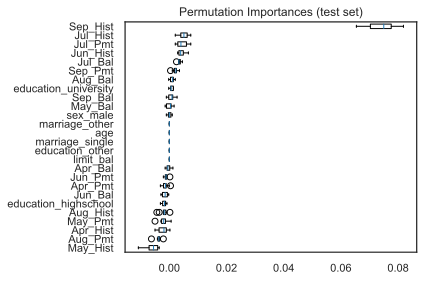

In [14]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [15]:
# September History seems to have a significant importance compared to the other features

## Metric Performance

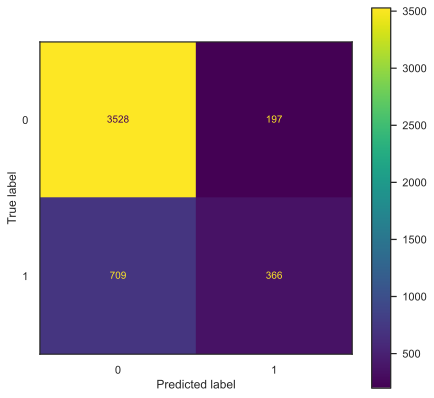

In [16]:
# Random Forest Confusion Matrix

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(rf, X_test_scaled, y_test, ax=ax);

In [17]:
# Random Forest Classification Report

y_preds_rf = rf.predict(X_test_scaled)

print(classification_report(y_test, y_preds_rf))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      3725
           1       0.65      0.34      0.45      1075

    accuracy                           0.81      4800
   macro avg       0.74      0.64      0.67      4800
weighted avg       0.79      0.81      0.79      4800



In [18]:
# False Negative - incorrectly predicted person will not default when in fact they did
# False Positive - incorrectly predicted person will default when in fact they didn't

# False Negatives are more detrimental to a financial institution because it leads to higher losses.
#   Higher number of defaults would slip through the cracks, forcing the bank to eat those losses
#   We want to optimize Recall (TP/TP + FN)

# Hyperparameter Tuning

In [19]:
# Define the parameter values that should be searched

bootstrap = [True, False]
max_features = ['auto','sqrt']
min_samples_leaf = [1,2,4]
min_samples_split = [2,5,10]
n_estimators = [50,100,150,200]
max_depth = [4,6,10,12, None]

In [20]:
# Specify "parameter distributions" rather than a "parameter grid"

param_dist = dict(n_estimators=n_estimators, max_depth = max_depth, bootstrap=bootstrap,
                  min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,
                  max_features=max_features)
print(param_dist)

{'n_estimators': [50, 100, 150, 200], 'max_depth': [4, 6, 10, 12, None], 'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt']}


In [22]:
# n_iter controls the number of searches

rand = RandomizedSearchCV(RandomForestClassifier(), param_dist, cv=10, scoring='accuracy',
                          n_iter=10, random_state=42)
rand.fit(X_train_scaled, y_train)
rand.cv_results_

{'mean_fit_time': array([1.21839545, 3.84268539, 1.1430263 , 2.33449724, 1.50607266,
        0.89247379, 1.92825921, 1.7201093 , 1.2766382 , 1.69605308]),
 'std_fit_time': array([0.01783213, 0.02212286, 0.01583794, 0.02413329, 0.03935772,
        0.10452308, 0.16746291, 0.1220464 , 0.01402053, 0.13127792]),
 'mean_score_time': array([0.01471379, 0.04573281, 0.01892669, 0.02757082, 0.01514902,
        0.01456075, 0.03192775, 0.02018919, 0.01483972, 0.02057471]),
 'std_score_time': array([0.0005147 , 0.00219482, 0.00031207, 0.00078515, 0.00123956,
        0.00189855, 0.00523966, 0.00193482, 0.00042224, 0.00227952]),
 'param_n_estimators': masked_array(data=[50, 150, 150, 150, 100, 100, 200, 100, 50, 150],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[5, 2, 5, 5, 10, 5, 2, 2, 5, 5],
              mask=[False, False, False, Fals

In [23]:
def get_best_model(model_grid):
    best_k = model_grid.cv_results_['rank_test_score'][0]
    print (f"Mean score: {model_grid.cv_results_['mean_test_score'][best_k]}",
           f"Std: {model_grid.cv_results_['std_test_score'][best_k]}")

In [24]:
# Examine the best model
print(rand.best_score_)
print(rand.best_params_)
get_best_model(rand)

0.8188194444444445
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
Mean score: 0.8186805555555555 Std: 0.00567960464738674


# Dealing with Class Imbalance

## Under/Oversampling

In [ ]:
# Balance data by undersampling/oversampling. Training data in each fold. Validating/testing on untouched data

In [25]:
# Cross Validation

# this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

kf = KFold(n_splits=10, shuffle=True, random_state = 42)
rf_under_scores, rf_over_scores = [],[]
rus = RandomUnderSampler(random_state=42)

for train_ind, val_ind in kf.split(X,y):

    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    ros = RandomOverSampler()
    rus = RandomUnderSampler()
    
    # Create undersampling of the data
    X_train_under, y_train_under = rus.fit_sample(X_train, y_train)
    # Create oversampling of the data
    X_train_over, y_train_over = ros.fit_sample(X_train, y_train)
    
    # Scale the features
    scaler_under = StandardScaler()
    X_train_under_scaled = scaler_under.fit_transform(X_train_under)
    X_val_scaled = scaler_under.transform(X_val)
    
    scaler_over = StandardScaler()
    X_train_over_scaled = scaler_over.fit_transform(X_train_over)
    X_val_scaled = scaler_over.transform(X_val)
    
    # Random Forest - Undersampling
    rf_under = RandomForestClassifier(n_estimators=150, max_depth=10, min_samples_split=5,
                                      min_samples_leaf=2, bootstrap=True, max_features='sqrt')
    rf_under.fit(X_train_under_scaled, y_train_under)
    rf_under_scores.append(rf_under.score(X_val_scaled,y_val))
    
    # Random Forest - Oversampling
    rf_over = RandomForestClassifier(n_estimators=150, max_depth=10, min_samples_split=5,
                                      min_samples_leaf=2, bootstrap=True, max_features='sqrt')
    rf_over.fit(X_train_over_scaled, y_train_over)
    rf_over_scores.append(rf_over.score(X_val_scaled, y_val))
        
rf_val_under_score = round(np.mean(rf_under_scores),4)
rf_val_over_score = round(np.mean(rf_over_scores),4)

print(f'Random Forest undersampling val score: {rf_val_under_score}')
print(f'Random forest oversampling val score: {rf_val_over_score}')

# Test

X_test_scaled = scaler.transform(X_test)

print(f'Random forest undersampling test score: {rf_under.score(X_test_scaled,y_test)}')
print(f'Random forest oversampling test score: {rf_over.score(X_test_scaled,y_test)}')

Random Forest undersampling val score: 0.781
Random forest oversampling val score: 0.7821
Random forest undersampling test score: 0.7320833333333333
Random forest oversampling test score: 0.776875


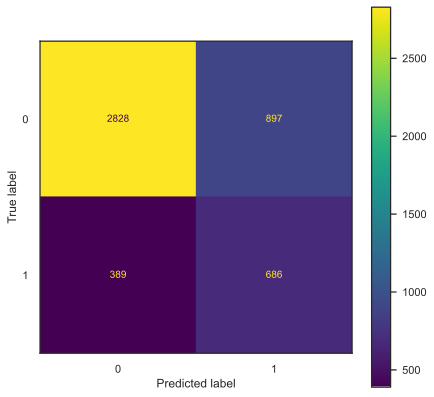

In [26]:
# Confusion Matrices
# Undrsampling
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(rf_under, X_test_scaled, y_test, ax=ax);

## Threshold Analysis

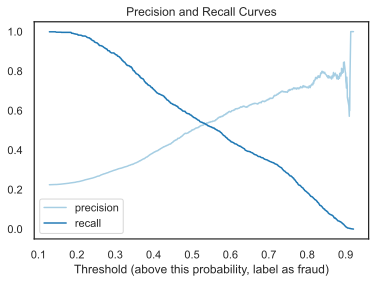

In [27]:
# Precision/Recall Curves

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, 
                                                                        rf_over.predict_proba(X_test_scaled)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [28]:
def make_confusion_matrix(model, threshold=0.5):
    """
    Predict class 1 if probability of being in class 1 is greater than threshold
    (model.predict(X_test) does this automatically with a threshold of 0.5)
    """
    y_predict = (model.predict_proba(X_test_scaled)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [29]:
# Interactive Confusion matrix

interactive(lambda threshold: make_confusion_matrix(rf_under, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [30]:
# Scenario 1: Low Threshold to capture recall
# Scenario 2: Mid Threshold to get a good balance
# Scenario 1: High Threshold to capture precision

In [32]:
# Cross Validation

kf = KFold(n_splits=10, shuffle=True, random_state = 42)
rf_under_scores_low, rf_under_scores_mid, rf_under_scores_high = [],[],[]
rus = RandomOverSampler(random_state=42)
thresh_low = 0.10
thresh_mid = 0.40
thresh_high = 0.90

print("\nCalculating val scores\n...")

for train_ind, val_ind in kf.split(X,y):

    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    # Undersample the data
    X_train_under, y_train_under = rus.fit_sample(X_train, y_train)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_under_scaled = scaler.fit_transform(X_train_under)
    X_val_scaled = scaler.transform(X_val)
    
    # Random Forest
    rf_under = RandomForestClassifier(n_estimators=150, max_depth=10, min_samples_split=5,
                                      min_samples_leaf=2, bootstrap=True, max_features='sqrt')
    rf_under.fit(X_train_under_scaled, y_train_under)
    rf_under_scores_low.append(accuracy_score(y_val, rf_under.predict_proba(X_val_scaled)[:,1]>thresh_low))
    rf_under_scores_mid.append(accuracy_score(y_val, rf_under.predict_proba(X_val_scaled)[:,1]>thresh_mid))
    rf_under_scores_high.append(accuracy_score(y_val, rf_under.predict_proba(X_val_scaled)[:,1]>thresh_high))
        
rf_val_under_score_low = round(np.mean(rf_under_scores_low),4)
rf_val_under_score_mid = round(np.mean(rf_under_scores_mid),4)
rf_val_under_score_high = round(np.mean(rf_under_scores_high),4)

print(f'Random forest oversampling, low threshold val score: {rf_val_under_score_low}')
print(f'Random forest oversampling, mid threshold val score: {rf_val_under_score_mid}')
print(f'Random forest oversampling, high threshold val score: {rf_val_under_score_high}')

# Test

print("\nCalculating test scores\n...")

X_test_scaled = scaler.transform(X_test)

print(f'Random forest oversampling, low threshold test score: {accuracy_score(y_test, rf_under.predict_proba(X_test_scaled)[:,1]>thresh_low)}')
print(f'Random forest oversampling, mid threshold test score: {accuracy_score(y_test, rf_under.predict_proba(X_test_scaled)[:,1]>thresh_mid)}')
print(f'Random forest oversampling, high threshold test score: {accuracy_score(y_test, rf_under.predict_proba(X_test_scaled)[:,1]>thresh_high)}')

Calculating val scores...
Random forest oversampling, low threshold val score: 0.2213
Random forest oversampling, mid threshold val score: 0.71
Random forest oversampling, high threshold val score: 0.7901
Calculating test scores...
Random forest oversampling, low threshold test score: 0.22395833333333334
Random forest oversampling, mid threshold test score: 0.7095833333333333
Random forest oversampling, high threshold test score: 0.7870833333333334


In [33]:
# Classification Report with low threshold

print(classification_report(y_test, rf_under.predict_proba(X_test_scaled)[:,1]>thresh_low))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3725
           1       0.22      1.00      0.37      1075

    accuracy                           0.22      4800
   macro avg       0.11      0.50      0.18      4800
weighted avg       0.05      0.22      0.08      4800



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
# Classification Report with mid threshold

print(classification_report(y_test, rf_under.predict_proba(X_test_scaled)[:,1]>thresh_mid))

              precision    recall  f1-score   support

           0       0.89      0.72      0.79      3725
           1       0.41      0.68      0.51      1075

    accuracy                           0.71      4800
   macro avg       0.65      0.70      0.65      4800
weighted avg       0.78      0.71      0.73      4800



In [35]:
# Classification Report with mid threshold

print(classification_report(y_test, rf_under.predict_proba(X_test_scaled)[:,1]>thresh_high))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      3725
           1       0.87      0.06      0.11      1075

    accuracy                           0.79      4800
   macro avg       0.83      0.53      0.49      4800
weighted avg       0.81      0.79      0.71      4800



In [36]:
# F_beta scores

print(fbeta_score(y_test, rf_under.predict_proba(X_test_scaled)[:,1]>thresh_low, average='weighted', beta=3.0))
print(fbeta_score(y_test, rf_under.predict_proba(X_test_scaled)[:,1]>thresh_mid, average='weighted', beta=1.0))
print(fbeta_score(y_test, rf_under.predict_proba(X_test_scaled)[:,1]>thresh_high, average='weighted', beta=0.2))

0.1663248416810593
0.7302483959626069
0.7415000665357532


In [37]:
# Log Loss Cross-Entropy Score

print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, rf_under.predict_proba(X_test_scaled)[:,1]>thresh_low)))
print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, rf_under.predict_proba(X_test_scaled)[:,1]>thresh_mid)))
print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, rf_under.predict_proba(X_test_scaled)[:,1]>thresh_high)))

Log-loss on logit: 26.8042
Log-loss on logit: 10.0308
Log-loss on logit: 7.3539


## Winner

Undersampling with Random Forest seems to have the highest recall rate. All models sacrifice True Positives in order to increase recall rate.

Furthermore, it makes more sense to use undersampling because it is less computationally expensive as I have 30,000 rows in my data

Trade-off question: Do we want high recall rate or strong true positives?

# ROC Curve

ROC AUC score =  0.7718793819260186


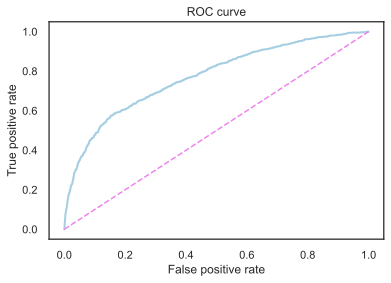

In [38]:
# ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, rf_over.predict_proba(X_test_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, rf_over.predict_proba(X_test_scaled)[:,1]))